### 3. تفاوت مجموع درآمد افراد دانشگاهی و غیر دانشگاهی

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def get_total_job_income(df, member_id):
    return df[df['Member_id'] == member_id]['netincome_w_y'].apply(to_int).sum()


def get_total_free_income(df, member_id):
    return df[df['Member_id'] == member_id]['income_s_y'].apply(to_int).sum()


def get_total_subsidy_income(df, member_id):
    return df[df['Member_id'] == member_id]['subsidy'].apply(to_int).sum()


def to_int(num):
    try:
        if type(num) == str:
            num = num.strip()
        return int(num)
    except Exception as e:
        return 0


def get_total_other_income(record):
    total_income = 0

    total_income += to_int(record['income_pension'])
    total_income += to_int(record['income_rent'])
    total_income += to_int(record['income_interest'])
    total_income += to_int(record['income_aid'])
    total_income += to_int(record['income_resale'])
    total_income += to_int(record['income_transfer'])

    return total_income


def get_total_income(df, member_id):
    return df[df['Member_id'] == member_id]['income'].apply(to_int).sum()


def calc_total_person_income(file_name):
    df_job_income = pd.read_excel(file_name, engine='openpyxl', sheet_name=file_name.split('.')[0] + 'P4S01')

    df_job_income = df_job_income[(~np.isnan(df_job_income['Address'])) & (~np.isnan(df_job_income['member']))]
    df_job_income['Member_id'] = df_job_income.apply(lambda r: str(r['Address']) + '_' + str(int(r['member'])), axis=1)
    df_job_income['income'] = df_job_income.apply(lambda r: get_total_job_income(df_job_income, r['Member_id']), axis=1)
    df_job_income.drop_duplicates(subset=['Member_id'], inplace=True)
    df_job_income = df_job_income[['Member_id', 'income']]

    df_free_income = pd.read_excel(file_name, engine='openpyxl', sheet_name=file_name.split('.')[0] + 'P4S02')

    df_free_income = df_free_income[(~np.isnan(df_free_income['Address'])) & (~np.isnan(df_free_income['member']))]
    df_free_income['Member_id'] = df_free_income.apply(lambda r: str(r['Address']) + '_' + str(int(r['member'])), axis=1)
    df_free_income['income'] = df_free_income.apply(lambda r: get_total_free_income(df_free_income, r['Member_id']), axis=1)
    df_free_income.drop_duplicates(subset=['Member_id'], inplace=True)
    df_free_income = df_free_income[['Member_id', 'income']]
    
    df_other_income = pd.read_excel(file_name, engine='openpyxl', sheet_name=file_name.split('.')[0] + 'P4S03')

    df_other_income.fillna(0, inplace=True)
    df_other_income = df_other_income[(~np.isnan(df_other_income['Address'])) & (~np.isnan(df_other_income['member']))]
    df_other_income['Member_id'] = df_other_income.apply(lambda r: str(r['Address']) + '_' + str(int(r['member'])), axis=1)
    df_other_income['income'] = df_other_income.apply(lambda r: get_total_other_income(r), axis=1)
    df_other_income.drop_duplicates(subset=['Member_id'], inplace=True)
    df_other_income = df_other_income[['Member_id', 'income']]
    
    df_subsidy_income = pd.read_excel(file_name, engine='openpyxl', sheet_name=file_name.split('.')[0] + 'P4S04')

    df_subsidy_income = df_subsidy_income[(~np.isnan(df_subsidy_income['Address'])) & (~np.isnan(df_subsidy_income['member']))]
    df_subsidy_income['Member_id'] = df_subsidy_income.apply(lambda r: str(r['Address']) + '_' + str(int(r['member'])), axis=1)
    df_subsidy_income['income'] = df_subsidy_income.apply(lambda r: get_total_subsidy_income(df_subsidy_income, r['Member_id']), axis=1)
    df_subsidy_income.drop_duplicates(subset=['Member_id'], inplace=True)
    df_subsidy_income = df_subsidy_income[['Member_id', 'income']]

    df_income = pd.concat([df_job_income, df_free_income, df_other_income, df_subsidy_income])
    
    df_educational_data = pd.read_excel(file_name, engine='openpyxl', sheet_name= file_name.split('.')[0] + 'P1')
    df_educational_data['Member_id'] = df_educational_data.apply(lambda r: str(r['Address']) + '_' + str(int(r['member'])), axis=1)

    degrees = ['Bachelor', 'Master', 'PhD']

    df_educated = df_educational_data[df_educational_data['degree'].isin(degrees)]
    df_educated = df_income.merge(df_educated, on='Member_id')

    df_not_educated = df_educational_data[~df_educational_data['degree'].isin(degrees)]
    df_not_educated = df_income.merge(df_not_educated, on='Member_id')

    educated_income = df_educated['income']
    not_educated_income = df_not_educated['income']

    return educated_income, not_educated_income

### مقایسه درآمد افراد دانشگاهی و غیر دانشگاهی در سال 1398

In [3]:
R98_educated_income, R98_not_educated_income = calc_total_person_income('R98.xlsx')
U98_educated_income, U98_not_educated_income = calc_total_person_income('U98.xlsx')

In [4]:
educated_income_98 = pd.concat([R98_educated_income, U98_educated_income], ignore_index=True)
not_educated_income_98 = pd.concat([R98_not_educated_income, U98_not_educated_income], ignore_index=True)

In [5]:
educated_income_98.mean(), not_educated_income_98.mean()

(117847193.09550749, 71617792.52744643)

In [6]:
educated_income_98.std(), not_educated_income_98.std()

(192356328.8321949, 127439354.21267503)

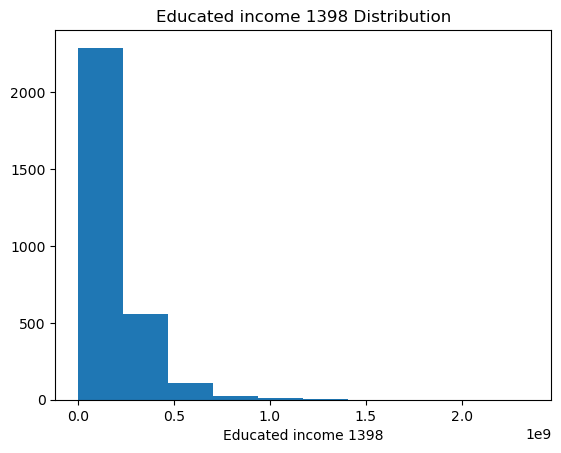

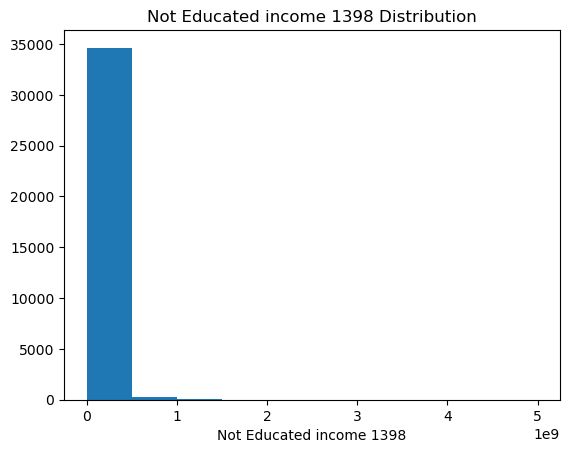

In [7]:
plt.hist(educated_income_98)
plt.xlabel('Educated income 1398')
plt.title('Educated income 1398 Distribution')
plt.show()
plt.hist(not_educated_income_98)
plt.xlabel('Not Educated income 1398')
plt.title('Not Educated income 1398 Distribution')
plt.show()

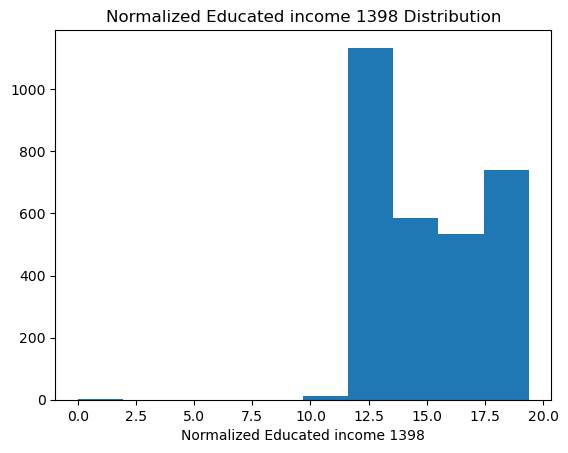

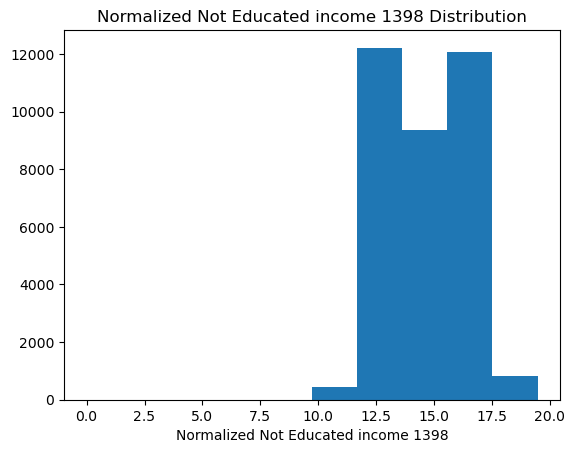

In [8]:
from scipy import stats

educated_income_normal, _ = stats.yeojohnson(educated_income_98)
not_educated_income_normal, _ = stats.yeojohnson(not_educated_income_98)

plt.hist(educated_income_normal, bins=10)
plt.xlabel('Normalized Educated income 1398')
plt.title('Normalized Educated income 1398 Distribution')
plt.show()
plt.hist(not_educated_income_normal, bins=10)
plt.xlabel('Normalized Not Educated income 1398')
plt.title('Normalized Not Educated income 1398 Distribution')
plt.show()

In [9]:
from scipy.stats import shapiro

shapiro(educated_income_normal), shapiro(not_educated_income_normal)

c:\Users\a\miniconda3\envs\quera\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 34959.
  res = hypotest_fun_out(*samples, **kwds)


(ShapiroResult(statistic=0.8804687905531232, pvalue=3.012525058573198e-43),
 ShapiroResult(statistic=0.9384994036615069, pvalue=9.802066219120336e-78))

چون داده های همچنان نرمال نیستند، پس باید از روش آماری دیگری برای بررسی این سوال استفاده کرد

In [10]:
from scipy.stats import mannwhitneyu

u_stat, p_value = mannwhitneyu(educated_income_98, not_educated_income_98)
u_stat, p_value

(53251129.0, 0.20838476492445912)

مقدار متغیر پی در این سوال برابر 0.20 است و از مقدار 0.05 بیشتر است یعنی نمی توان فرض اولیه برابری درامد افراد دانشگاهی و غیر دانشگاهی را رد کرد
نتیجه می شود که در سال 1398 درآمد افراد دانشگاهی و غیر دانشگاهی تقریبا برابر بوده است

### مقایسه درآمد افراد دانشگاهی و غیر دانشگاهی در سال 1399

In [11]:
R99_educated_income, R99_not_educated_income = calc_total_person_income('R99.xlsx')
U99_educated_income, U99_not_educated_income = calc_total_person_income('U99.xlsx')

In [12]:
educated_income_99 = pd.concat([R99_educated_income, U99_educated_income], ignore_index=True)
not_educated_income_99 = pd.concat([R99_not_educated_income, U99_not_educated_income], ignore_index=True)

In [13]:
educated_income_99.mean(), not_educated_income_99.mean()

(144718752.9396307, 91399525.5831413)

In [14]:
educated_income_99.std(), not_educated_income_99.std()

(280615951.2226038, 166262989.35897785)

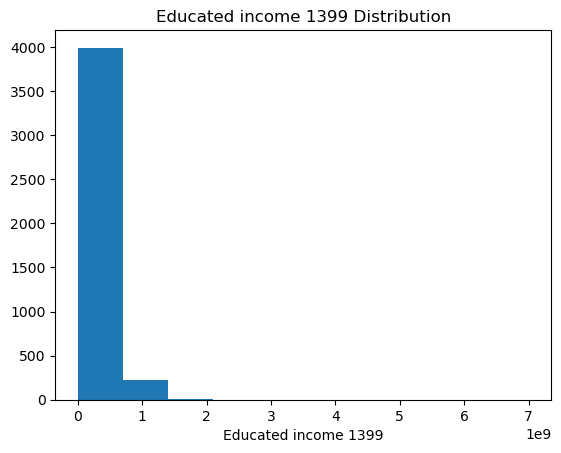

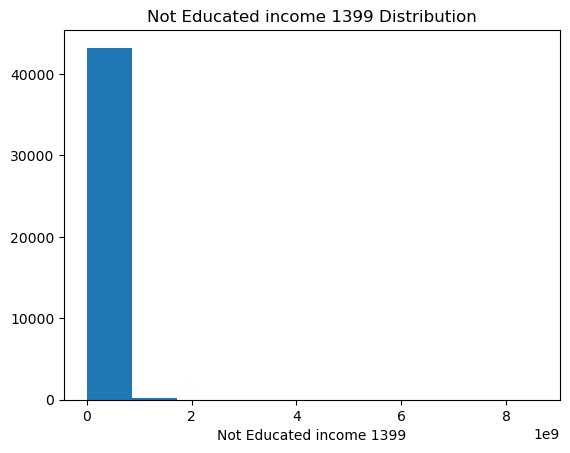

In [15]:
plt.hist(educated_income_99)
plt.xlabel('Educated income 1399')
plt.title('Educated income 1399 Distribution')
plt.show()
plt.hist(not_educated_income_99)
plt.xlabel('Not Educated income 1399')
plt.title('Not Educated income 1399 Distribution')
plt.show()

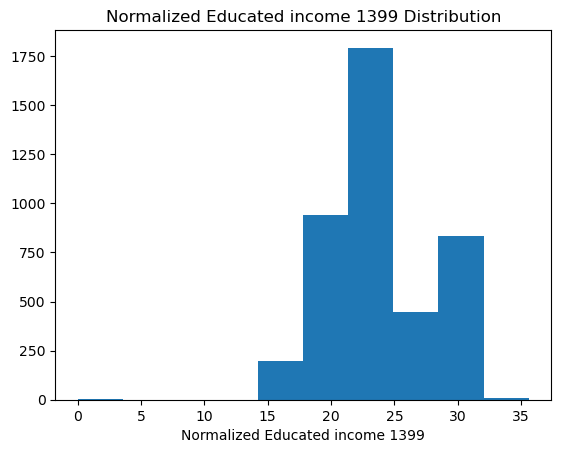

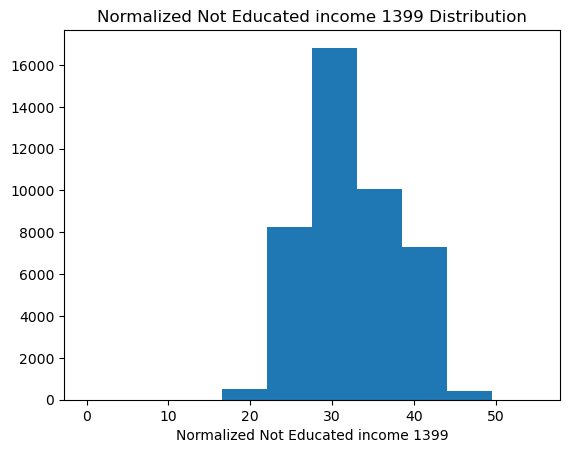

In [16]:
from scipy import stats

educated_income_normal, _ = stats.yeojohnson(educated_income_99)
not_educated_income_normal, _ = stats.yeojohnson(not_educated_income_99)

plt.hist(educated_income_normal, bins=10)
plt.xlabel('Normalized Educated income 1399')
plt.title('Normalized Educated income 1399 Distribution')
plt.show()
plt.hist(not_educated_income_normal, bins=10)
plt.xlabel('Normalized Not Educated income 1399')
plt.title('Normalized Not Educated income 1399 Distribution')
plt.show()

In [17]:
from scipy.stats import shapiro

shapiro(educated_income_normal), shapiro(not_educated_income_normal)

c:\Users\a\miniconda3\envs\quera\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 43396.
  res = hypotest_fun_out(*samples, **kwds)


(ShapiroResult(statistic=0.9352978249518522, pvalue=1.846852075085842e-39),
 ShapiroResult(statistic=0.9660524305993815, pvalue=4.841788078248587e-69))

چون داده های همچنان نرمال نیستند، پس باید از روش آماری دیگری برای بررسی این سوال استفاده کرد

In [18]:
from scipy.stats import mannwhitneyu

u_stat, p_value = mannwhitneyu(educated_income_99, not_educated_income_99)
u_stat, p_value

(87000620.5, 4.9072816255175154e-08)

مقدار پی در این قسمت برابر با عددی بسیار کوچک و نزدیک به صفر شده است. این موضوع نشان می دهد که فرض اولیه برابری درآمدهای افراد دانشگاهی و غیر دانشگاهی در سال
1399 فرض اشتباهی بوده است و درآمد این دو گروه در این سال یکسان نمی باشد

### مقایسه درآمد افراد دانشگاهی و غیر دانشگاهی در سال 1400

In [19]:
R1400_educated_income, R1400_not_educated_income = calc_total_person_income('R1400.xlsx')
U1400_educated_income, U1400_not_educated_income = calc_total_person_income('U1400.xlsx')

In [20]:
educated_income_1400 = pd.concat([R1400_educated_income, U1400_educated_income], ignore_index=True)
not_educated_income_1400 = pd.concat([R1400_not_educated_income, U1400_not_educated_income], ignore_index=True)

In [21]:
educated_income_1400.mean(), not_educated_income_1400.mean()

(201557482.83226222, 133783826.129118)

In [22]:
educated_income_1400.std(), not_educated_income_1400.std()

(403333452.4682052, 247556926.00087586)

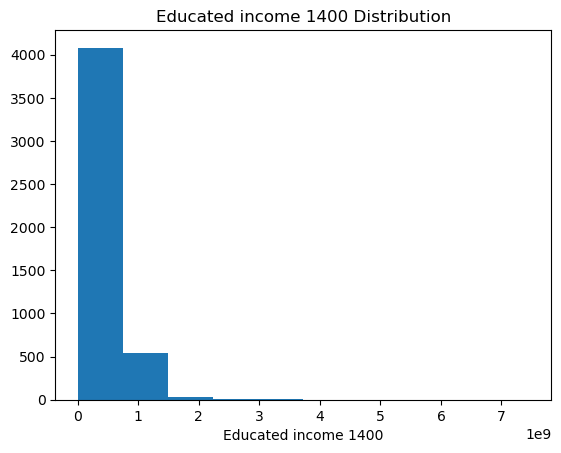

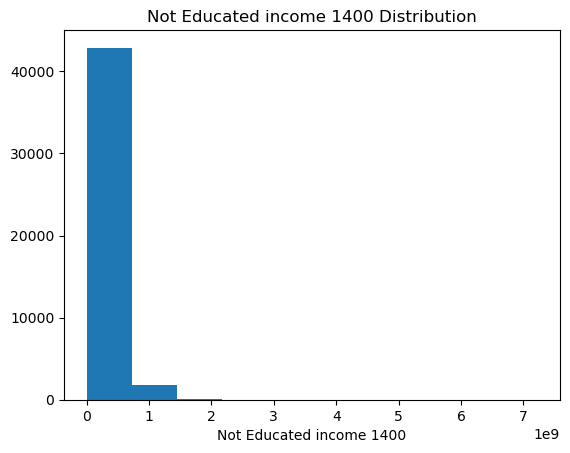

In [23]:
plt.hist(educated_income_1400)
plt.xlabel('Educated income 1400')
plt.title('Educated income 1400 Distribution')
plt.show()
plt.hist(not_educated_income_1400)
plt.xlabel('Not Educated income 1400')
plt.title('Not Educated income 1400 Distribution')
plt.show()

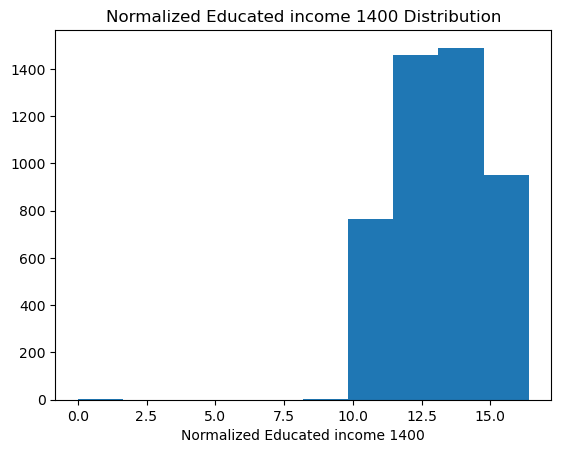

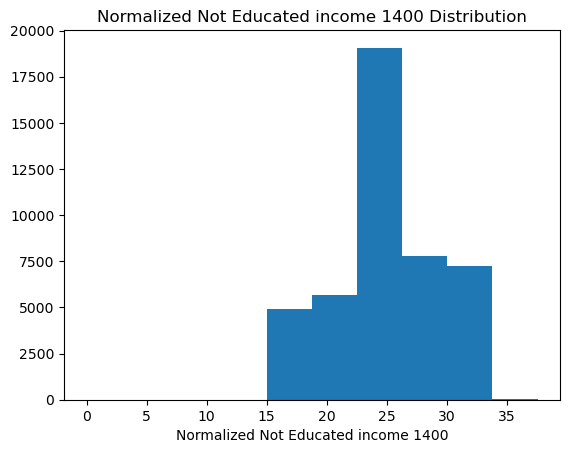

In [24]:
from scipy import stats

educated_income_normal, _ = stats.yeojohnson(educated_income_1400)
not_educated_income_normal, _ = stats.yeojohnson(not_educated_income_1400)

plt.hist(educated_income_normal, bins=10)
plt.xlabel('Normalized Educated income 1400')
plt.title('Normalized Educated income 1400 Distribution')
plt.show()
plt.hist(not_educated_income_normal, bins=10)
plt.xlabel('Normalized Not Educated income 1400')
plt.title('Normalized Not Educated income 1400 Distribution')
plt.show()

In [25]:
from scipy.stats import shapiro

shapiro(educated_income_normal), shapiro(not_educated_income_normal)

c:\Users\a\miniconda3\envs\quera\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 44773.
  res = hypotest_fun_out(*samples, **kwds)


(ShapiroResult(statistic=0.9331247254522355, pvalue=1.4703936319443063e-41),
 ShapiroResult(statistic=0.9649728078067079, pvalue=2.732892531457362e-70))

چون داده های همچنان نرمال نیستند، پس باید از روش آماری دیگری برای بررسی این سوال استفاده کرد

In [26]:
from scipy.stats import mannwhitneyu

u_stat, p_value = mannwhitneyu(educated_income_1400, not_educated_income_1400)
u_stat, p_value

(94313927.5, 4.905419750004765e-28)

مقدار پی در این قسمت برابر با عددی بسیار کوچک و نزدیک به صفر شده است. این موضوع نشان می دهد که فرض اولیه برابری درآمدهای افراد دانشگاهی و غیر دانشگاهی در سال
1400 فرض اشتباهی بوده است و درآمد این دو گروه در این سال یکسان نمی باشد

### مقایسه درآمد افراد دانشگاهی و غیر دانشگاهی در سال 1401

In [27]:
R1401_educated_income, R1401_not_educated_income = calc_total_person_income('R1401.xlsx')
U1401_educated_income, U1401_not_educated_income = calc_total_person_income('U1401.xlsx')

In [28]:
educated_income_1401 = pd.concat([R1401_educated_income, U1401_educated_income], ignore_index=True)
not_educated_income_1401 = pd.concat([R1401_not_educated_income, U1401_not_educated_income], ignore_index=True)

In [29]:
educated_income_1401.mean(), not_educated_income_1401.mean()

(880025218.8693367, 590622874.1391596)

In [30]:
educated_income_1401.std(), not_educated_income_1401.std()

(854124560.18687, 709961606.6712936)

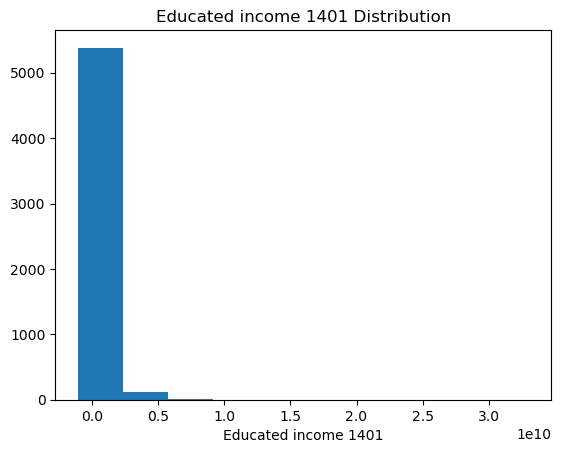

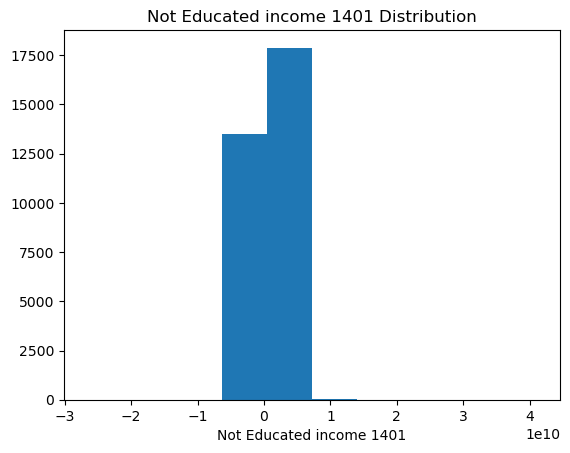

In [31]:
plt.hist(educated_income_1401)
plt.xlabel('Educated income 1401')
plt.title('Educated income 1401 Distribution')
plt.show()
plt.hist(not_educated_income_1401)
plt.xlabel('Not Educated income 1401')
plt.title('Not Educated income 1401 Distribution')
plt.show()

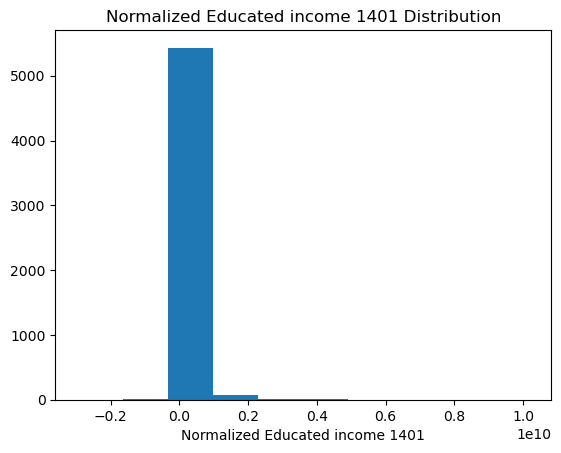

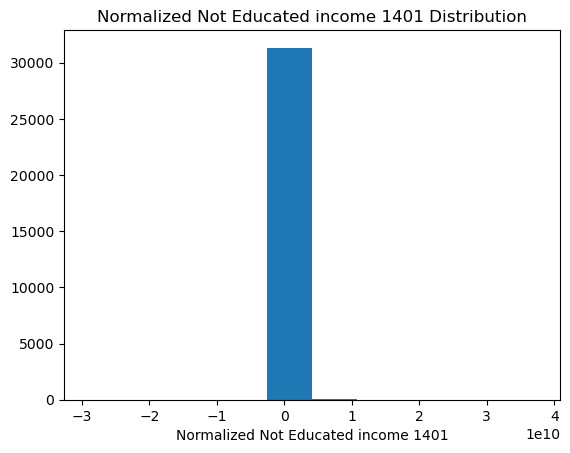

In [32]:
from scipy import stats

educated_income_normal, _ = stats.yeojohnson(educated_income_1401)
not_educated_income_normal, _ = stats.yeojohnson(not_educated_income_1401)

plt.hist(educated_income_normal, bins=10)
plt.xlabel('Normalized Educated income 1401')
plt.title('Normalized Educated income 1401 Distribution')
plt.show()
plt.hist(not_educated_income_normal, bins=10)
plt.xlabel('Normalized Not Educated income 1401')
plt.title('Normalized Not Educated income 1401 Distribution')
plt.show()

In [33]:
from scipy.stats import shapiro

shapiro(educated_income_normal), shapiro(not_educated_income_normal)

c:\Users\a\miniconda3\envs\quera\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5518.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\a\miniconda3\envs\quera\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 31410.
  res = hypotest_fun_out(*samples, **kwds)


(ShapiroResult(statistic=0.5851655769453947, pvalue=1.7538603252732048e-78),
 ShapiroResult(statistic=0.4795206137294675, pvalue=5.697002819761656e-130))

چون داده های همچنان نرمال نیستند، پس باید از روش آماری دیگری برای بررسی این سوال استفاده کرد

In [34]:
from scipy.stats import mannwhitneyu

u_stat, p_value = mannwhitneyu(educated_income_1401, not_educated_income_1401)
u_stat, p_value

(115749137.0, 0.0)

مقدار پی در این قسمت برابر با صفر شده است. این موضوع نشان می دهد که فرض اولیه برابری درآمدهای افراد دانشگاهی و غیر دانشگاهی در سال
1401 فرض اشتباهی بوده است و درآمد این دو گروه در این سال یکسان نمی باشد و درواقع تفاوت این دو گروه بسیار زیاد می باشد

### مقایسه درآمد افراد دانشگاهی و غیر دانشگاهی در مجموع سالهای گذشته

In [35]:
educated_income = pd.concat([educated_income_98, educated_income_99, educated_income_1400, educated_income_1401])

In [36]:
not_educated_income = pd.concat([not_educated_income_98, not_educated_income_99, not_educated_income_1400, not_educated_income_1401])

In [37]:
educated_income.mean(), not_educated_income.mean()

(388301597.2007465, 200671860.28784508)

In [38]:
educated_income.std(), not_educated_income.std()

(642791898.6582797, 413473559.14591265)

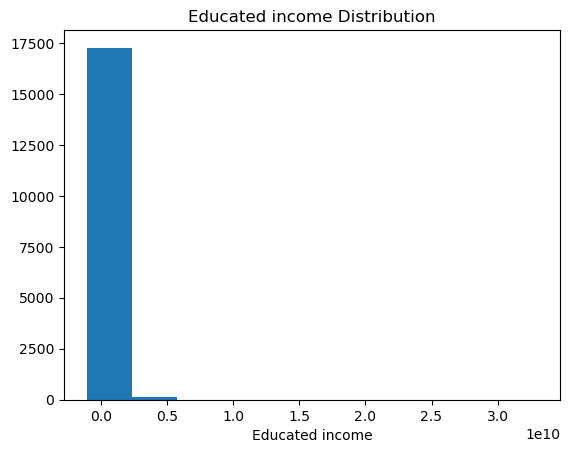

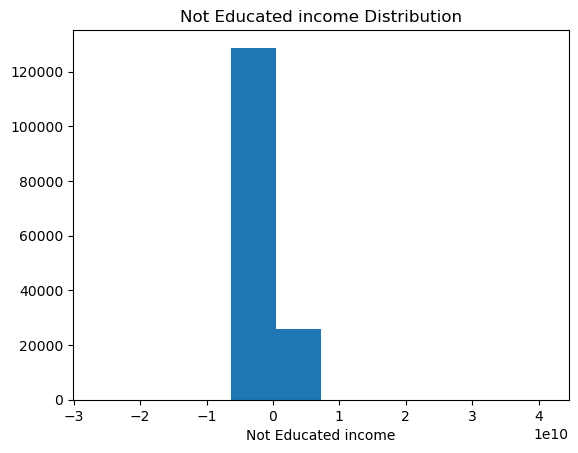

In [39]:
plt.hist(educated_income)
plt.xlabel('Educated income')
plt.title('Educated income Distribution')
plt.show()

plt.hist(not_educated_income)
plt.xlabel('Not Educated income')
plt.title('Not Educated income Distribution')
plt.show()

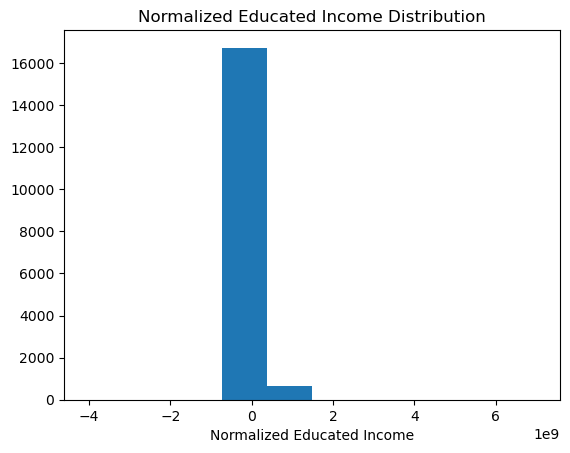

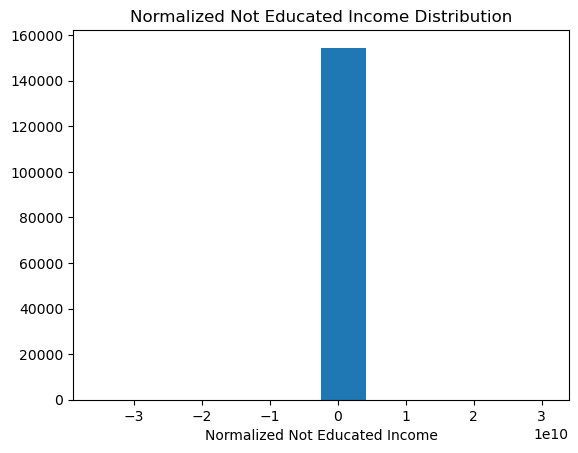

In [40]:
educated_income_normal, _ = stats.yeojohnson(educated_income)
not_educated_income_normal, _ = stats.yeojohnson(not_educated_income)

plt.hist(educated_income_normal, bins=10)
plt.xlabel('Normalized Educated Income')
plt.title('Normalized Educated Income Distribution')
plt.show()
plt.hist(not_educated_income_normal, bins=10)
plt.xlabel('Normalized Not Educated Income')
plt.title('Normalized Not Educated Income Distribution')
plt.show()

In [41]:
shapiro(educated_income_normal), shapiro(not_educated_income_normal)

c:\Users\a\miniconda3\envs\quera\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17415.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\a\miniconda3\envs\quera\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 154538.
  res = hypotest_fun_out(*samples, **kwds)


(ShapiroResult(statistic=0.5992339984447053, pvalue=1.1282974250812287e-106),
 ShapiroResult(statistic=0.4423807086728988, pvalue=4.9840841581040425e-176))

چون مقدار متغیر پی بسیار کمتر از 0.05 است پس میتوان فرض نرمال شدن داده ها را رد کرده و نتیجه گرفت که داده ها نرمال نیستند یا به عبارتی هنوز نرمال نشده اند
بنابراین از تست آماری دیگری استفاده می کنیم.

In [42]:
u_stat, p_value = mannwhitneyu(educated_income, not_educated_income)
u_stat, p_value

(1518229575.0, 5.341212716512871e-170)

مقدار متغیر پی بسیار نزدیک به عدد صفر است. این موضوع نشان می دهد که برابری درآمد افراد دانشگاهی و غیر دانشگاهی با احتمال بسیار بالا رد شده و این یعنی
تفاوت معناداری بین درآمد افراد دانشگاهی و غیر دانشگاهی در مجموع سالهای گذشته وجود دارد